In [2]:
import os
import csv, json, pickle
from itertools import combinations, product
from functools import wraps
from collections import defaultdict
import bisect

from Bio import SeqIO

import numpy as np
import statsmodels.stats.multitest as ssm
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, roc_auc_score

%matplotlib inline
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gs
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

sns.set_style("white")

plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Calibri'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.handlelength'] = 1.3

plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['lines.dashed_pattern'] = (2.8,2.8)

plt.rcParams['svg.fonttype'] = 'none'


blue = "#007EEA"
orange = "#FEB80A"
green = "#7FD13B"
pink = "#EA157A"
white = "#FFFFFF"
purple = "#754AB2"
black = "#000000"

# Load Data


In [2]:
import scipy.integrate as integrate
def load_roc_curve(ifile):
    reader = csv.reader(open(ifile, 'r'), delimiter=','); next(reader)
    
    data = [list(map(float, t)) for t in reader]
    if not data[0][0] == 0:
        data = [[0.0,0.0], *data]
    
    fpr, tpr = [t[0] for t in data], [t[1] for t in data] 
    
    auroc = integrate.trapz(tpr, fpr)
    
    return fpr, tpr, auroc

In [3]:
domains = ["Kinase_TK", "PDZ", "PTB", "PTP","SH2","SH3","WH1","WW"]
motif_baseline_fmt = "../pssm/output/{0}_roc.csv"
hsmid_baseline_fmt = "data/perf/hsmid/{0}.csv"
hsmd_fmt = "data/perf/hsmd/{0}.csv"
ifiles_format = [hsmd_fmt, hsmid_baseline_fmt, motif_baseline_fmt]

prediction_data = dict()
for domain in domains:
    prediction_data[domain] = [load_roc_curve(ifmt.format(domain)) for ifmt in ifiles_format]

In [4]:
comparison_data = defaultdict(list)

fpr, tpr, auroc = load_roc_curve(os.path.join("../netphorest/PTB", "PTB_roc.csv"))
comparison_data["PTB"].append(("NetPhorest", auroc, fpr, tpr, 6/33))

fpr, tpr, auroc = load_roc_curve(os.path.join("../netphorest/Kinase_TK", "Kinase_TK_roc.csv"))
comparison_data["Kinase_TK"].append(("NetPhorest", auroc, fpr, tpr, 56/94))

fpr, tpr, auroc = load_roc_curve(os.path.join("../netphorest/SH2", "SH2_roc.csv"))
comparison_data["SH2"].append(("NetPhorest", auroc, fpr, tpr, 89/120))

fpr, tpr, auroc = load_roc_curve(os.path.join("../netphorest/PTP", "PTP_roc.csv"))
comparison_data["PTP"].append(("NetPhorest", auroc, fpr, tpr, 22/49))

fpr, tpr, auroc = load_roc_curve(os.path.join("../pepint/SH2", "SH2_roc.csv"))
comparison_data["SH2"].append(("SH2PepInt", auroc, fpr, tpr, 48/120))

fpr, tpr, auroc = load_roc_curve(os.path.join("../pepint/PDZ", "PDZ_roc.csv"))
comparison_data["PDZ"].append(("PDZPepInt", auroc, fpr, tpr, 105/270))

In [5]:
output_directory = "plots/fig_2_supp_fig_3/"
if not os.path.exists(output_directory): os.makedirs(output_directory)

# Domain-Level Performance

In [37]:
colors = [blue, blue, orange] # HSM-D, HSM-ID, PSSM
label_base = ["HSM/D", "HSM/ID", "PSSM"]

labels_size=27.5
tic_size=25
def plot_domain_subplot(domain, ax, predictions=prediction_data, colors=colors,
                        ext_comparisons=comparison_data, ext_comparison_color=green,
                        labels_size=labels_size, tic_size=tic_size):
    """
    Plots input domain data for a single domain on a passed in axis.
    
    Inputs:
        domain: string of the domain that is being plotted. Index into predictions and ext_comparisons
        ax: matplotlib axis to plot onto
        predictions: dictionary mapping domain keys to prediction data in order (HSM/D, HSM/ID, PSSM) 
        colors: three colors assigned to HSM/D, HSM/ID, PSSM (in that order). 
        ext_comparisons: dictionary mapping domain keys to external comparisons in list format as follows
            [(Comparison name, AUROC, FPRs, TPRs, Percentage of domains covered)]
        ext_comparison_color: color assigned to external comparisons (e.g. PepInt)
    """

    ax.plot([0,1],[0,1], ls='--', c='#696969', lw=2.5)
        
    # Plots the data for HSM/D, HSM/ID, PSSM
    for idx, (color, data) in enumerate(zip(colors, predictions[domain])):
        fpr, tpr, auroc = data
        ls = '-' if idx != 1 else '--'
        label = "{0:.2f}".format(auroc)
        ax.plot(fpr, tpr, lw=2.5, color=color, ls=ls, label=label)
        
    # Plots the data for any available external comparisons. 
    # Note, this data is pretty simplistic. If more comparisons are added
    # this will need to be extended.
    for name, auroc, fpr, tpr, pctage in ext_comparisons.get(domain, list()):        
        ls = '-' if "NetPhorest" in name else '--'
        label = "{0:.2f} ({1}%)".format(auroc, int(round(pctage,2) * 100))
        ax.plot(fpr, tpr, lw=2.5, color=ext_comparison_color, ls=ls, label=label)
        ax.legend(fontsize=tic_size)
        
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    # Pretty formatting of the ticks axes.
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: " 0" if x < 1e-7 else (str(x)[:8].rstrip('0') if x != 1.0 else "1.0")))
    minorLocatorX = AutoMinorLocator()
    ax.xaxis.set_minor_locator(minorLocatorX)
    ax.tick_params(axis='x', which='major', direction='in', bottom=True, left=True, width=1, length=8, labelsize=tic_size)
    ax.tick_params(axis='x', which='minor', direction='in', bottom=True, left=True, width=1, length=5)
    
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "0" if x < 1e-7 else (str(x)[:8].rstrip('0') if x != 1.0 else "1.0")))
    minorLocatorY = AutoMinorLocator()
    ax.yaxis.set_minor_locator(minorLocatorY)
    ax.tick_params(axis='y', which='major', direction='in', bottom=True, left=True, width=1, length=8, labelsize=tic_size)
    ax.tick_params(axis='y', which='minor', direction='in', bottom=True, left=True, width=1, length=5)
    
    # Sets grid
    ax.grid(which='major', axis='y', color='#DCDCDC', linewidth=1)

## Supplementary Fig 3a

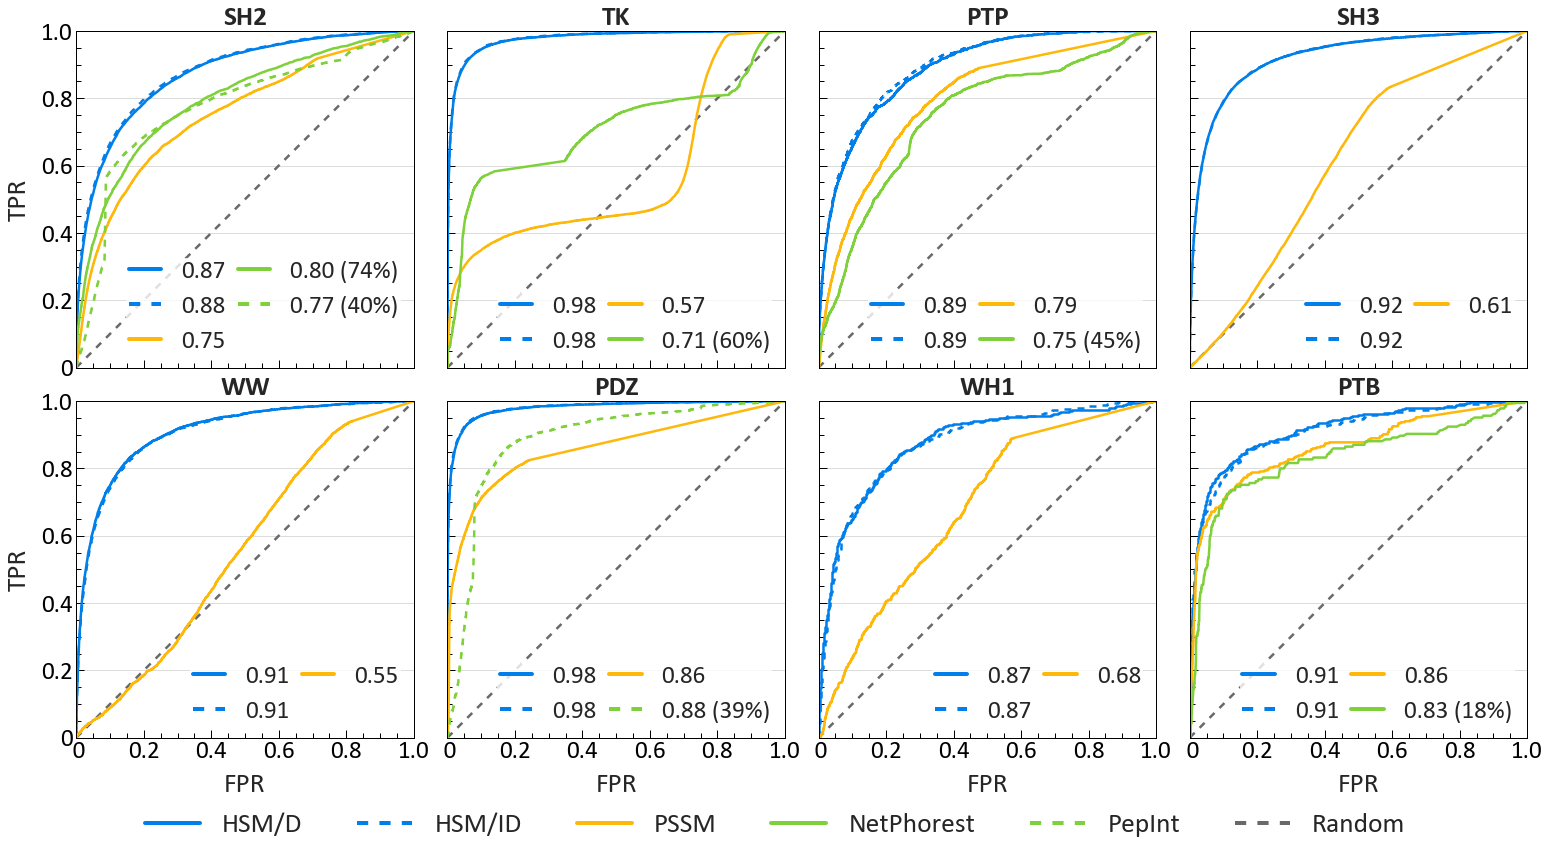

In [52]:
fig, axes = plt.subplots(2,4, figsize=(26,13), gridspec_kw={"wspace":0.1, "hspace":0.1})
plt.subplots_adjust(wspace=.25, hspace=0.25) # Adjust inter-subplot spacing with these functions

# Iterate over each domain, plot per domain
for idx, domain in enumerate(["SH2", "Kinase_TK", "PTP", "SH3", "WW", "PDZ", "WH1", "PTB"]):
    ridx, cidx = idx // 4, idx % 4
    plot_domain_subplot(domain, ax=axes[ridx, cidx])
    axes[ridx,cidx].set_title(domain.replace("Kinase_TK", "TK"),fontsize=labels_size, weight='bold')
    
    legend = axes[ridx, cidx].legend(loc='lower right', ncol=2, frameon=True, edgecolor='None', fontsize=tic_size, labelspacing=0.5, borderpad=0.1, columnspacing=0.5)
    for l in legend.get_lines(): l.set_linewidth(4.0)
        
    axes[ridx,cidx].set_xticks(np.arange(0, 1.2, 0.2))

# Remove ticks and labels from interior plots
for idx in range(1,4):
    axes[0,idx].set_yticklabels([])
    axes[0,idx].set_xticklabels([])
    axes[1,idx].set_yticklabels([])
    
    axes[1,idx].set_xlabel("FPR", fontsize=labels_size, labelpad=10)
    
axes[0,0].set_xticklabels([])    
axes[1,0].set_xlabel("FPR", fontsize=labels_size, labelpad=10)
for idx in range(2): axes[idx,0].set_ylabel("TPR", fontsize=labels_size, labelpad=10)

# Creates legend with appropriate linestyles / colors / etc. 
linestyles = [Line2D([0], [0], color=c, lw=4, ls=ls) for c,ls in zip( [blue, blue, orange, green, green, '#696969'], ['-', '--', '-', '-', '--', '--']) ]
fig.legend(linestyles, ["HSM/D", "HSM/ID", "PSSM", "NetPhorest", "PepInt", "Random"], 
           loc='lower center', ncol=len(linestyles), frameon=False, handlelength=2, fontsize=labels_size, borderaxespad=0.25)

fig.savefig(os.path.join(output_directory, "expanded_data.pdf"), dpi=500, transparent=True, bbox_inches='tight')

## Fig 2a

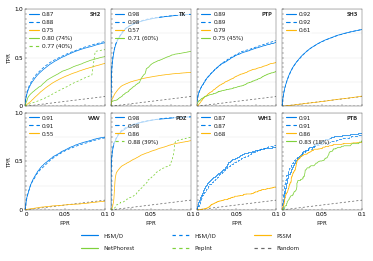

In [294]:
colors = [blue, blue, orange] # HSM-D, HSM-ID, PSSM
label_base = ["HSM/D", "HSM/ID", "PSSM"]

labels_size=7
tic_size=6.75
line_width=0.74
def plot_domain_subplot(domain, ax, predictions=prediction_data, colors=colors,
                        ext_comparisons=comparison_data, ext_comparison_color=green,
                        labels_size=labels_size, tic_size=tic_size, lw=line_width):
    """
    Plots input domain data for a single domain on a passed in axis.
    
    Inputs:
        domain: string of the domain that is being plotted. Index into predictions and ext_comparisons
        ax: matplotlib axis to plot onto
        predictions: dictionary mapping domain keys to prediction data in order (HSM/D, HSM/ID, PSSM) 
        colors: three colors assigned to HSM/D, HSM/ID, PSSM (in that order). 
        ext_comparisons: dictionary mapping domain keys to external comparisons in list format as follows
            [(Comparison name, AUROC, FPRs, TPRs, Percentage of domains covered)]
        ext_comparison_color: color assigned to external comparisons (e.g. PepInt)
    """

    ax.plot([0,1],[0,1], ls='--', c='#696969', lw=lw)
        
    # Plots the data for HSM/D, HSM/ID, PSSM
    for idx, (color, data) in enumerate(zip(colors, predictions[domain])):
        fpr, tpr, auroc = data
        label = "{0:.2f}".format(auroc)
        if idx != 1:
            ax.plot(fpr, tpr, lw=lw, color=color, ls='-', label=label)
        else:
            ax.plot(fpr, tpr, lw=lw, color=color, ls='--', dashes=(3.2,3.2), dash_capstyle='round', label=label)
        ax.legend(fontsize=tic_size)
        
    # Plots the data for any available external comparisons. 
    # Note, this data is pretty simplistic. If more comparisons are added
    # this will need to be extended.
    for name, auroc, fpr, tpr, pctage in ext_comparisons.get(domain, list()):        
        ls = '-' if "NetPhorest" in name else '--'
        label = "{0:.2f} ({1}%)".format(auroc, int(round(pctage,2) * 100))
        ax.plot(fpr, tpr, lw=lw, color=ext_comparison_color, ls=ls, label=label)
        ax.legend(fontsize=tic_size)
        
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    # Pretty formatting of the ticks axes.      
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "  0" if x < 1e-7 else (str(x)[:8].rstrip('0') if x % 0.05 == 0 and x != 1.0 else ("1.0" if x == 1 else ""))))
    minorLocatorX = AutoMinorLocator()
    ax.xaxis.set_minor_locator(minorLocatorX)
    ax.tick_params(axis='x', which='major', direction='in', bottom=True, left=True, width=0.3, length=2.4, labelsize=tic_size, pad=2)
    ax.tick_params(axis='x', which='minor', direction='in', bottom=True, left=True, width=0.3, length=1.5)
    
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: " 0" if x < 1e-7 else (str(x)[:8].rstrip('0') if x % 0.5 == 0 and x != 1.0 else ("1.0" if x == 1 else ""))))
    minorLocatorY = AutoMinorLocator()
    ax.yaxis.set_minor_locator(minorLocatorY)
    ax.tick_params(axis='y', which='major', direction='in', bottom=True, left=True, width=0.3, length=2.4, labelsize=tic_size, pad=2)
    ax.tick_params(axis='y', which='minor', direction='in', bottom=True, left=True, width=0.3, length=1.5)
    
    # Sets grid
    ax.grid(which='major', axis='y', color='#DCDCDC', linewidth=0.3)
    for a in ['top', 'bottom', 'left', 'right']:
        ax.spines[a].set_linewidth(0.3)
    
scale_x = 1.285
scale_y = 1.305
plot_specs = {
    'fig_top': 0.0, 'fig_bot': 0.05, 'fig_left': 0.035, 'fig_right': 0.0,
    'subplot_height': 1.352*scale_y, 'subplot_width': 1.105*scale_x,
    'subplot_wspace': 0.0827*scale_x, 'subplot_hspace': 0.089*scale_y,
    'ncols': 4, 'nrows': 2}

def get_plot_specs(plot_specs):
    xsize = plot_specs['fig_left'] + plot_specs['fig_right'] + plot_specs['subplot_width']*plot_specs['ncols'] + (plot_specs['ncols']-1)*plot_specs['subplot_wspace']
    ysize = plot_specs['fig_top'] + plot_specs['fig_bot'] + plot_specs['subplot_height']*plot_specs['nrows'] + (plot_specs['nrows']-1)*plot_specs['subplot_hspace']
    return xsize, ysize

xsize, ysize = get_plot_specs(plot_specs)
gs_kw = {'wspace': plot_specs['subplot_wspace']/plot_specs['subplot_width'],
        'hspace': plot_specs['subplot_hspace']/plot_specs['subplot_height']}

fig, axes = plt.subplots(plot_specs['nrows'], plot_specs['ncols'], figsize=(xsize, ysize), gridspec_kw=gs_kw)

# Iterate over each domain, plot per domain
for idx, domain in enumerate(["SH2", "Kinase_TK", "PTP", "SH3", "WW", "PDZ", "WH1", "PTB"]):
    ridx, cidx = idx // 4, idx % 4
    plot_domain_subplot(domain, ax=axes[ridx, cidx])
    
    axes[ridx,cidx].set_xticks(np.arange(0, 0.125, 0.025))
    axes[ridx,cidx].set_yticks(np.arange(0, 1.25, 0.25))
    
# Remove ticks and labels from interior plots
for idx in range(1,4):
    axes[0,idx].set_yticklabels([])
    axes[0,idx].set_xticklabels([])
    axes[1,idx].set_yticklabels([])
    
    axes[1,idx].set_xlabel("FPR", fontsize=labels_size, labelpad=plot_specs['fig_bot']*72) # labelpad=10
    

axes[0,0].set_xticklabels([])    
axes[1,0].set_xlabel("FPR", fontsize=labels_size, labelpad=plot_specs['fig_bot']*72)
for idx in range(2): axes[idx,0].set_ylabel("TPR", fontsize=labels_size, labelpad=plot_specs['fig_left']*72)

# Labels plots. Note, domain labels were adjusted manually.
for idx, domain in enumerate(["SH2", "Kinase_TK", "PTP", "SH3", "WW", "PDZ", "WH1", "PTB"]): 
    ridx, cidx = idx // 4, idx % 4
    axes[ridx,cidx].set_xlim([0,.1])
    legend = axes[ridx,cidx].legend(loc='upper left', ncol=1, frameon=True, edgecolor='None',
                                    framealpha=0.65, fontsize=labels_size, labelspacing=0.3,
                                    borderpad=0.1, handletextpad=0.5, bbox_to_anchor=[0.0001,1.02])
    for l in legend.get_lines(): l.set_linewidth(1.15)
    
    axes[ridx,cidx].text(0.095, 0.925, domain.replace("Kinase_TK", "TK"), weight='bold', horizontalalignment='right', fontsize=labels_size, bbox={'alpha':0.65, 'facecolor': 'white', 'pad': 1})
    
# Creates legend with appropriate linestyles / colors / etc. 
linestyles = [Line2D([0], [0], color=c, lw=1.2, ls=ls) for c,ls in zip( [blue, green, blue, green, orange,'#696969'], ['-', '-', '--', '--', '-', '--']) ]
fig.legend(linestyles, ["HSM/D", "NetPhorest", "HSM/ID", "PepInt", "PSSM", "Random"], 
           loc='lower left', bbox_to_anchor=[0.25,-0.035], ncol=3, columnspacing=5.6,
           frameon=False, handlelength=2.5, fontsize=tic_size, borderaxespad=-0.2, labelspacing=1)

fig.savefig(os.path.join(output_directory, "expanded_data.tight.pdf"), dpi=500, transparent=True, bbox_inches='tight')

## Supplementary Fig 3b

Code for the experimental proportion component of Supplementary Figure 3. Plots pre-processed data processed with the script included at `scripts/experimental_proportions.py`. The input to that file is the raw predictions from each model.

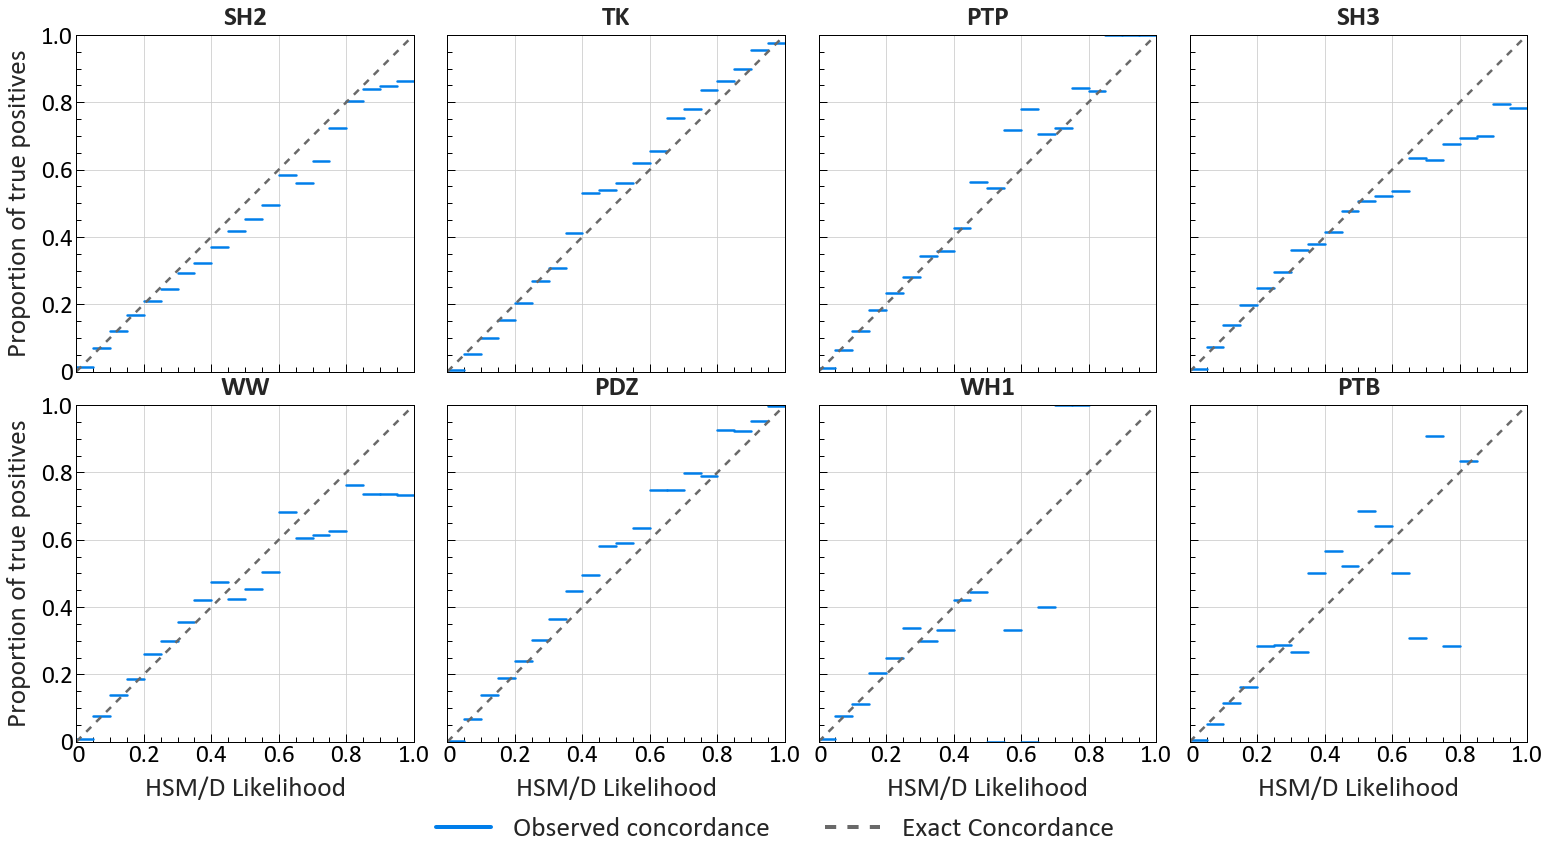

In [57]:
window_size=250
f, axes = plt.subplots(2, 4, figsize=(26,13), gridspec_kw={"wspace":.1, "hspace":.1})

labels_size=27.5
tic_size=25

xstep = 0.05

for idx, d in enumerate(["SH2", "Kinase_TK", "PTP", "SH3", "WW", "PDZ", "WH1", "PTB"]):
    ifile = "data/perf/hsmd_exp_proportions/{0}.csv".format(d)

    reader = csv.reader(open(ifile, 'r'), delimiter=','); next(reader)
    data = list(reader)
    
    predicted_range_start = [float(t[0]) for t in data]
    experimental_proportions = [float(t[1]) for t in data]
    
    ridx, cidx = (idx // 4, idx % 4)
    for start, end, exp_proportion in zip(predicted_range_start, predicted_range_start[1:], experimental_proportions):
        axes[ridx, cidx].plot([start, end], [exp_proportion, exp_proportion], c="#007EEA", lw=2.5)
    # Include final interval
    axes[ridx, cidx].plot([predicted_range_start[-1], 1.0], [experimental_proportions[-1], experimental_proportions[-1]], c="#007EEA", lw=2.5)
    
    axes[ridx, cidx].plot([0,1],[0,1], ls='--', c='#696969', lw=2.5)
    axes[ridx, cidx].set_xlim([0,1])
    axes[ridx, cidx].set_ylim([0,1])
    
    axes[ridx,cidx].set_xticks(np.arange(0, 1.2, 0.2))
    
    minorLocatorX = AutoMinorLocator()
    axes[ridx, cidx].xaxis.set_minor_locator(minorLocatorX)
    axes[ridx, cidx].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: " 0" if x < 1e-7 else (str(x)[:8].rstrip('0') if x != 1.0 else "1.0")))
    minorLocatorY = AutoMinorLocator()
    axes[ridx, cidx].yaxis.set_minor_locator(minorLocatorY)
    axes[ridx, cidx].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "0" if x < 1e-7 else (str(x)[:8].rstrip('0') if x != 1.0 else "1.0")))
    axes[ridx, cidx].tick_params(axis='both', which='major', direction='in', colors='k', bottom=True, left=True, width=1, length=8, labelsize=tic_size)
    axes[ridx, cidx].tick_params(axis='both', which='minor', direction='in', colors='k', bottom=True, left=True, width=1, length=5)
    axes[ridx, cidx].set_title(d.replace("Kinase_TK", "TK"),fontsize=labels_size, pad=10, weight='bold')
    
    axes[ridx, cidx].grid()
    
    
for cidx in range(1,4):
    axes[0,cidx].set_xticklabels([])
    axes[0,cidx].set_yticklabels([])
    axes[1,cidx].set_yticklabels([])
axes[0,0].set_xticklabels([])
for ridx in range(2):
    axes[ridx, 0].set_ylabel("Proportion of true positives", fontsize=labels_size, labelpad=10)
for cidx in range(4):
    axes[1, cidx].set_xlabel("HSM/D Likelihood", fontsize=labels_size, labelpad=10)
    
    
linestyles = [Line2D([0], [0], color='#007EEA', lw=4, ls='-'), Line2D([0], [0], color='#696969', lw=4, ls='--')]
f.legend(linestyles, ["Observed concordance", "Exact Concordance"], 
           loc='lower center', ncol=len(linestyles), frameon=False, handlelength=2, fontsize=labels_size, borderaxespad=0.25)

output_directory = "plots/fig_2_supp_fig_3/"
f.savefig(os.path.join(output_directory, "experimental_comparisons.pdf"), dpi=500, transparent=True, bbox_inches='tight')

# HSM/ID calibration curves

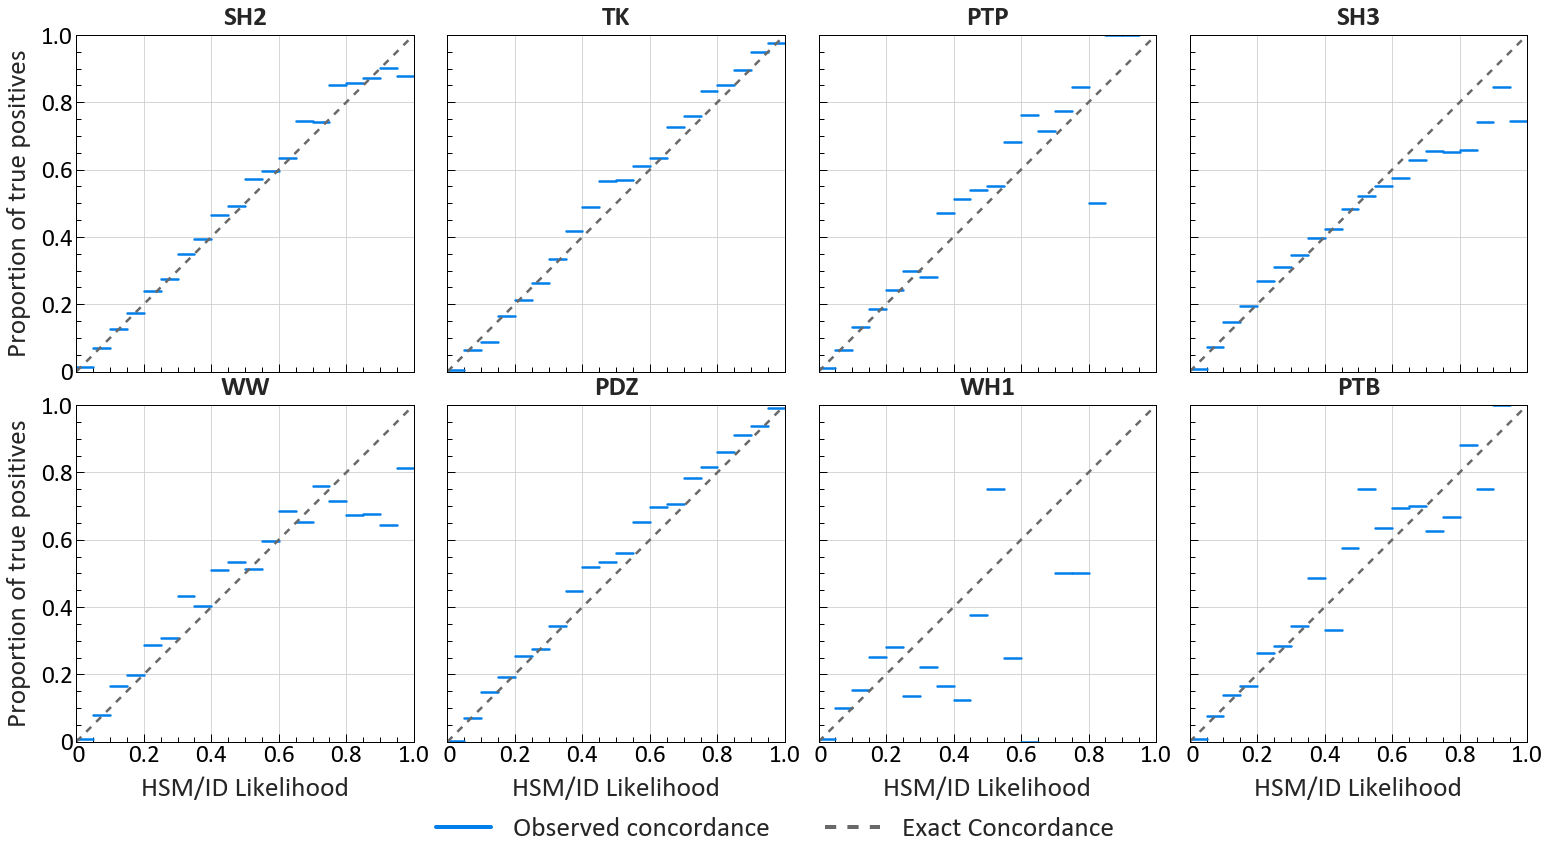

In [3]:
window_size=250
f, axes = plt.subplots(2, 4, figsize=(26,13), gridspec_kw={"wspace":.1, "hspace":.1})

labels_size=27.5
tic_size=25

xstep = 0.05

for idx, d in enumerate(["SH2", "Kinase_TK", "PTP", "SH3", "WW", "PDZ", "WH1", "PTB"]):
    ifile = "data/perf/hsmid_exp_proportions/{0}.csv".format(d)

    reader = csv.reader(open(ifile, 'r'), delimiter=','); next(reader)
    data = list(reader)
    
    predicted_range_start = [float(t[0]) for t in data]
    experimental_proportions = [float(t[1]) for t in data]
    
    ridx, cidx = (idx // 4, idx % 4)
    for start, end, exp_proportion in zip(predicted_range_start, predicted_range_start[1:], experimental_proportions):
        axes[ridx, cidx].plot([start, end], [exp_proportion, exp_proportion], c="#007EEA", lw=2.5)
    # Include final interval
    axes[ridx, cidx].plot([predicted_range_start[-1], 1.0], [experimental_proportions[-1], experimental_proportions[-1]], c="#007EEA", lw=2.5)
    
    axes[ridx, cidx].plot([0,1],[0,1], ls='--', c='#696969', lw=2.5)
    axes[ridx, cidx].set_xlim([0,1])
    axes[ridx, cidx].set_ylim([0,1])
    
    axes[ridx,cidx].set_xticks(np.arange(0, 1.2, 0.2))
    
    minorLocatorX = AutoMinorLocator()
    axes[ridx, cidx].xaxis.set_minor_locator(minorLocatorX)
    axes[ridx, cidx].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: " 0" if x < 1e-7 else (str(x)[:8].rstrip('0') if x != 1.0 else "1.0")))
    minorLocatorY = AutoMinorLocator()
    axes[ridx, cidx].yaxis.set_minor_locator(minorLocatorY)
    axes[ridx, cidx].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "0" if x < 1e-7 else (str(x)[:8].rstrip('0') if x != 1.0 else "1.0")))
    axes[ridx, cidx].tick_params(axis='both', which='major', direction='in', colors='k', bottom=True, left=True, width=1, length=8, labelsize=tic_size)
    axes[ridx, cidx].tick_params(axis='both', which='minor', direction='in', colors='k', bottom=True, left=True, width=1, length=5)
    axes[ridx, cidx].set_title(d.replace("Kinase_TK", "TK"),fontsize=labels_size, pad=10, weight='bold')
    
    axes[ridx, cidx].grid()
    
    
for cidx in range(1,4):
    axes[0,cidx].set_xticklabels([])
    axes[0,cidx].set_yticklabels([])
    axes[1,cidx].set_yticklabels([])
axes[0,0].set_xticklabels([])
for ridx in range(2):
    axes[ridx, 0].set_ylabel("Proportion of true positives", fontsize=labels_size, labelpad=10)
for cidx in range(4):
    axes[1, cidx].set_xlabel("HSM/ID Likelihood", fontsize=labels_size, labelpad=10)
    
    
linestyles = [Line2D([0], [0], color='#007EEA', lw=4, ls='-'), Line2D([0], [0], color='#696969', lw=4, ls='--')]
f.legend(linestyles, ["Observed concordance", "Exact Concordance"], 
           loc='lower center', ncol=len(linestyles), frameon=False, handlelength=2, fontsize=labels_size, borderaxespad=0.25)